## The Big Squeeze - The Effect of Inflation on Housing, Employment and Spending power

### Install and import the required libraries and dependencies

In [618]:
# Install the required libraries
!pip install prophet

In [619]:
!pip install hvplot

In [620]:
# Import the required libraries and dependencies
import pandas as pd
from prophet import Prophet
import hvplot.pandas
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

## Read the datasets

In [621]:
#Read Inflation rates (CPI) csv file into a dataframe and display the data

cpi_df=pd.read_csv("../Resources/Data/US_inflation_rates.csv",index_col='date',parse_dates=True).dropna()
cpi_df


,value
date,
1947-01-01,21.480
1947-02-01,21.620
1947-03-01,22.000
1947-04-01,22.000
1947-05-01,21.950
...,...
2023-02-01,301.648
2023-03-01,301.808
2023-04-01,302.918


In [622]:
#Read the Home price index dataset in to a data frame and display the data
hpi_df=pd.read_csv("../Resources/Data/Home-price-index.csv",index_col='DATE',parse_dates=True).dropna()
hpi_df

,CSUSHPISA
DATE,
1987-01-01,63.964
1987-02-01,64.424
1987-03-01,64.736
1987-04-01,65.132
1987-05-01,65.563
...,...
2023-03-01,298.396
2023-04-01,300.208
2023-05-01,302.685


In [623]:
#Read the Dataset for Mortgage rates and foreclosures along with HPI
housing_df=pd.read_csv("../Resources/Data/demand_data.csv",index_col='DATE',parse_dates=True).dropna()
housing_df

,UNEM_RATE,MORTGAGE,GDPC1,FORECLOSURES,HPI
DATE,,,,,
2000-01-01,4.03,8.26,12935.252,1.95,101.34
2000-04-01,3.93,8.32,13170.749,1.97,103.67
2000-07-01,4.00,8.02,13183.890,2.09,105.79
2000-10-01,3.90,7.62,13262.250,2.23,108.27
2001-01-01,4.23,7.01,13219.251,2.34,110.48
...,...,...,...,...,...
2019-10-01,3.60,3.70,19202.310,2.34,212.47
2020-01-01,3.80,3.52,18951.992,2.36,215.51
2020-04-01,13.07,3.24,17258.205,2.55,217.89


## Data Pre-processing

In [624]:
 
# Rename the index and column names in all the dataframes
cpi_df.index.name='Date'
hpi_df.index.name='Date'
housing_df.index.name='Date'
housing_df=housing_df[['MORTGAGE','FORECLOSURES','HPI']]

cpi_df=cpi_df.rename(columns={'value':'cpi_value'})
hpi_df=hpi_df.rename(columns={'CSUSHPISA':'hpi_value'})
housing_df=housing_df.rename(columns={'MORTGAGE':'Mortgage','FORECLOSURES':'Foreclosures'})




#Display the changed names
display(cpi_df.head())
display(hpi_df.head())
display(housing_df.head())

,cpi_value
Date,
1947-01-01,21.48
1947-02-01,21.62
1947-03-01,22.00
1947-04-01,22.00
1947-05-01,21.95


,hpi_value
Date,
1987-01-01,63.964
1987-02-01,64.424
1987-03-01,64.736
1987-04-01,65.132
1987-05-01,65.563


,Mortgage,Foreclosures,HPI
Date,,,
2000-01-01,8.26,1.95,101.34
2000-04-01,8.32,1.97,103.67
2000-07-01,8.02,2.09,105.79
2000-10-01,7.62,2.23,108.27
2001-01-01,7.01,2.34,110.48


In [625]:
# Slice the dataframe to align the timelines of both data frames to include 13 years of data from 2013-01-01 to 2023-06-01
cpi_df=cpi_df.loc['2010-01-01':'2023-06-01']
hpi_df=hpi_df.loc['2010-01-01':'2023-06-01']
housing_df=housing_df.loc['2010-01-01':'2023-06-01']

#Handle missing values
cpi_df.dropna()
hpi_df.dropna()
housing_df.dropna()

#hpi_df=hpi_df.resample('Q').mean().round(3)

display(cpi_df.head())
display(hpi_df.head())
display(housing_df.head())

,cpi_value
Date,
2010-01-01,217.488
2010-02-01,217.281
2010-03-01,217.353
2010-04-01,217.403
2010-05-01,217.290


,hpi_value
Date,
2010-01-01,147.396
2010-02-01,145.631
2010-03-01,145.859
2010-04-01,146.403
2010-05-01,146.394


,Mortgage,Foreclosures,HPI
Date,,,
2010-01-01,5.00,11.54,146.29
2010-04-01,4.92,11.08,146.17
2010-07-01,4.45,10.61,143.97
2010-10-01,4.44,10.37,142.25
2011-01-01,4.85,10.33,140.62


## Normalize the data for better comparison

In [626]:
# Normalize the CPI date by Indexing to 100 at a baseline year

def normalize_cpi(x):
    index= (x/217.488) * 100
    return index

cpi_df['cpi_value']=cpi_df['cpi_value'].apply(normalize_cpi)
cpi_df

,cpi_value
Date,
2010-01-01,100.000000
2010-02-01,99.904822
2010-03-01,99.937928
2010-04-01,99.960917
2010-05-01,99.908960
...,...
2023-02-01,138.696388
2023-03-01,138.769955
2023-04-01,139.280328


In [627]:
# Normalize the HPI data by Indexing both dataframes to 100 at a baseline year

def normalize_hpi(x):
    index= (x/147.396) * 100
    return index

hpi_df['hpi_value']=hpi_df['hpi_value'].apply(normalize_hpi)
hpi_df

,hpi_value
Date,
2010-01-01,100.000000
2010-02-01,98.802546
2010-03-01,98.957231
2010-04-01,99.326305
2010-05-01,99.320199
...,...
2023-02-01,201.683221
2023-03-01,202.445114
2023-04-01,203.674455


In [628]:
# Normalize the housing dataframe for comparing foreclosure rates and Home price index.

# Apply Min-Max normalization technique
for column in housing_df.columns: 
    housing_df[column] = (housing_df[column] - housing_df[column].min()) / (housing_df[column].max() - housing_df[column].min())     
  
# view normalized data 


housing_df.head()

,Mortgage,Foreclosures,HPI
Date,,,
2010-01-01,1.000000,1.000000,0.097038
2010-04-01,0.964286,0.950000,0.095781
2010-07-01,0.754464,0.898913,0.072752
2010-10-01,0.750000,0.872826,0.054747
2011-01-01,0.933036,0.868478,0.037684


## Visualizations
1. Explore the changes over time for each dataframe
2. Explore the relationship between two dataframes
3. Analyze time based trends

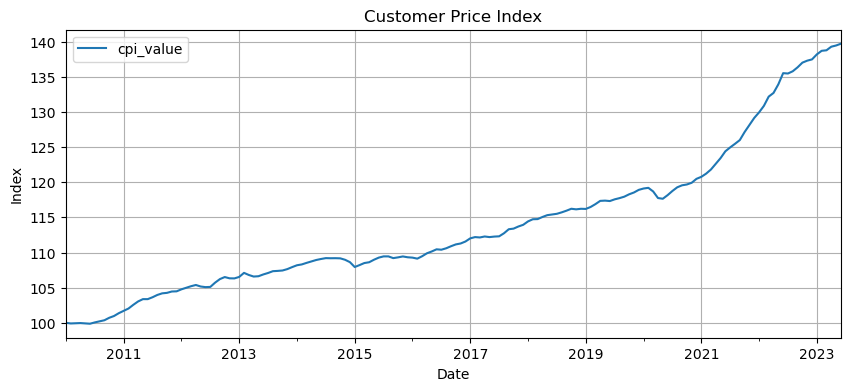

In [629]:
# Plot the CPI dataframe  to explore the changes over time
cpi_df.plot(title="Customer Price Index",figsize=(10,4),legend=True)
plt.ylabel('Index')
plt.grid()
plt.show()

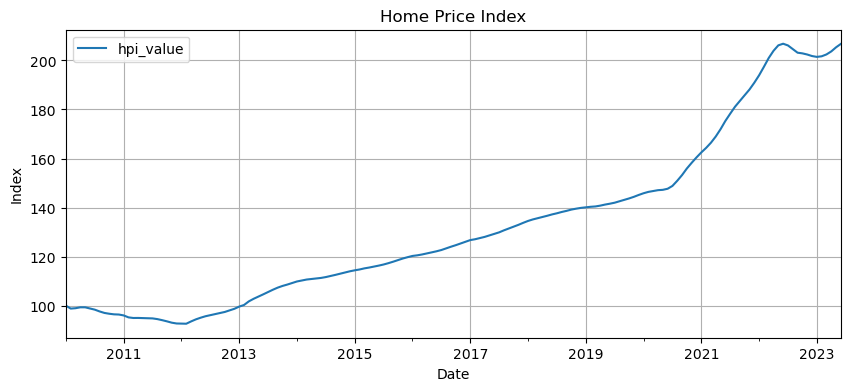

In [630]:
#Plot the HPI dataframe  to explore the changes over time
hpi_df.plot(title="Home Price Index",figsize=(10,4),legend=True)
plt.ylabel('Index')
plt.grid()
plt.show()

## Analysis
* The trends of two data look similar, which suggests there could be a correlation
* Both CPI value and HPI valued have a noticeable upward trend in mid-2020


## Is there a correlation?

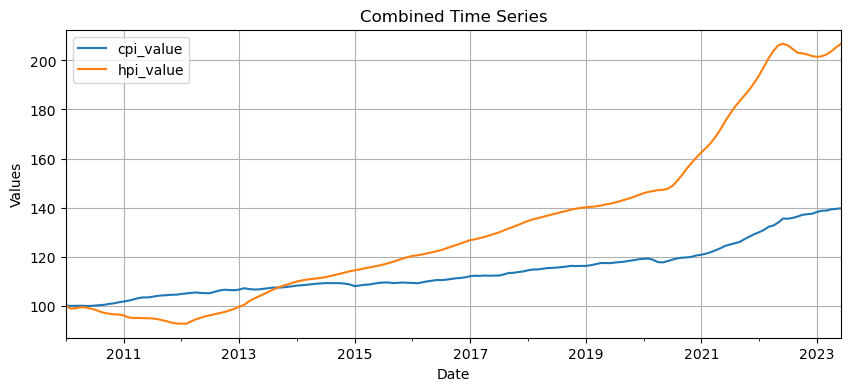

In [631]:
# Combine cpi and hpi data frames
combine_df=pd.concat([cpi_df,hpi_df],axis=1).dropna()
combine_df.plot(title='Combined Time Series', figsize=(10, 4))
plt.xlabel('Date')
plt.ylabel('Values')
plt.grid()
plt.show()

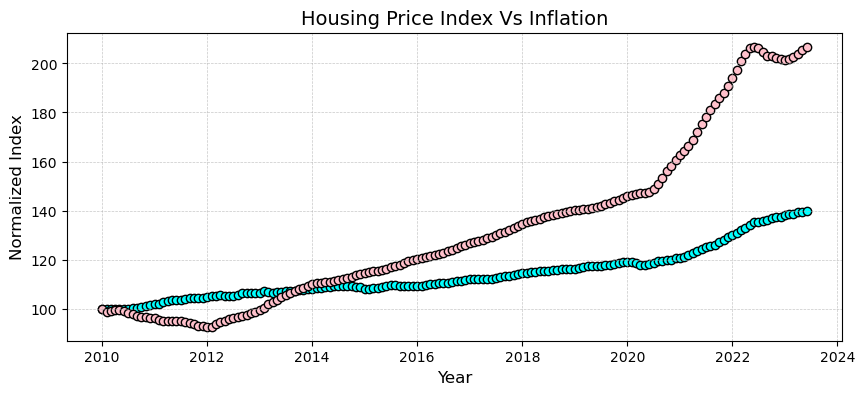

In [632]:
# Is there a correlation between these two data?
plt.figure(figsize=(10, 4))
plt.scatter(combine_df.index,combine_df['cpi_value'], marker="o", facecolors="cyan", edgecolors="black", label='Data Points')
plt.scatter(combine_df.index,combine_df['hpi_value'], marker="o", facecolors="pink", edgecolors="black", label='Data Points')
plt.title("Housing Price Index Vs Inflation", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Normalized Index", fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

## Analysis
* We could see a "Divergence" around 2010 when HPI and CPI moves further apart. Inflation continues to rise and HPI had a dip. 
* Both the values again "Converged" before 2014 and HPI started to rise faster than CPI.
* Inflation and HPI move in the same direction (Positive ). Generally, when inflation rates rise, HPI tends to rise as well.

## Correlation analysis

In [633]:
# calculate correlation between CPI and HPI data frames

combine_df.corr()


,cpi_value,hpi_value
cpi_value,1.000000,0.983688
hpi_value,0.983688,1.000000


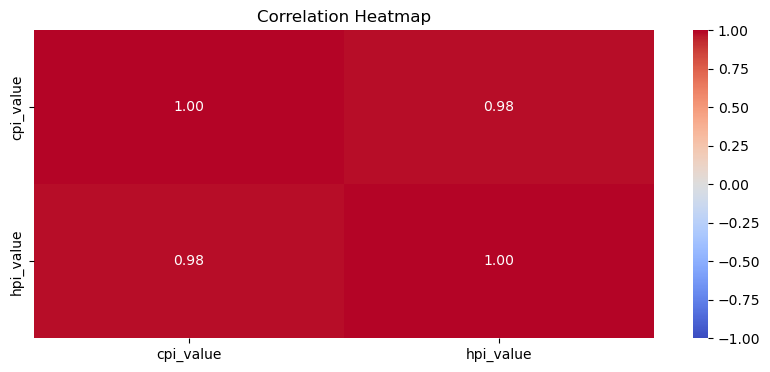

In [634]:
#Correlation heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(combine_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

## Descriptive statistics

In [635]:
# CPI dataframe
cpi_df.describe()

,cpi_value
count,162.000000
mean,113.918120
std,10.180115
min,99.867119
25%,106.929463
50%,111.021528
75%,118.472398
max,139.704719


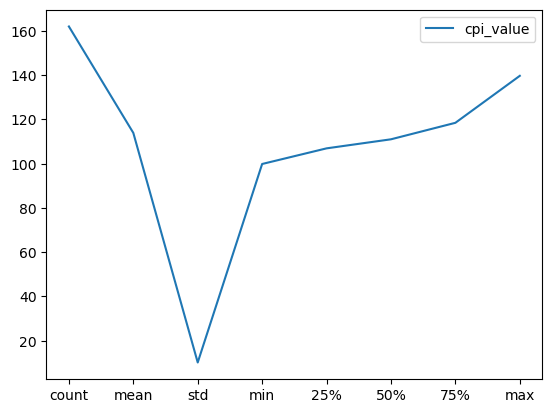

In [636]:
#Plot the statistical summary for CPI data
cpi_df.describe().plot()
plt.show()

In [637]:
# HPI dataframe summary statistics
hpi_df.describe()

,hpi_value
count,162.000000
mean,132.237101
std,33.976797
min,92.630058
25%,103.929041
50%,124.350729
75%,146.251086
max,206.811582


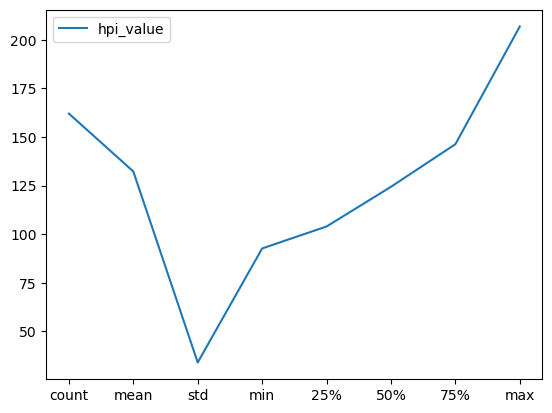

In [638]:
# Plot the statistical summary for HPI dataframe
hpi_df.describe().plot()
plt.show()

## Outlier detection

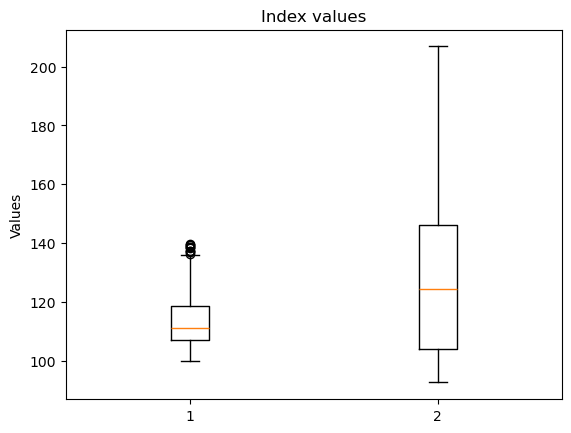

In [639]:
# Boxplots
fig1, ax1 = plt.subplots()
ax1.set_title('Index values')
ax1.set_ylabel('Values')
ax1.boxplot(combine_df)
#sns.boxplot(combine_df)
plt.show()

### Impact of HPI on Foreclosure Rates and Mortgage rates

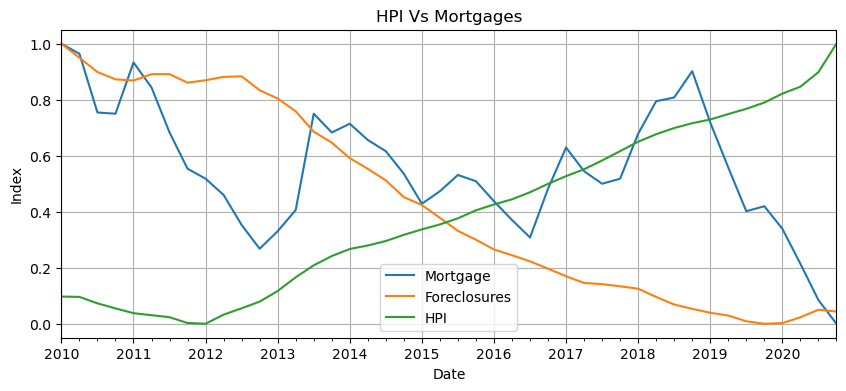

In [640]:
#Plot the housing dataframe
housing_df.plot(title="HPI Vs Mortgages",figsize=(10,4),legend=True)
plt.ylabel('Index')
plt.grid()
plt.show()

## Scatter Plot - HPI Vs Foreclosures

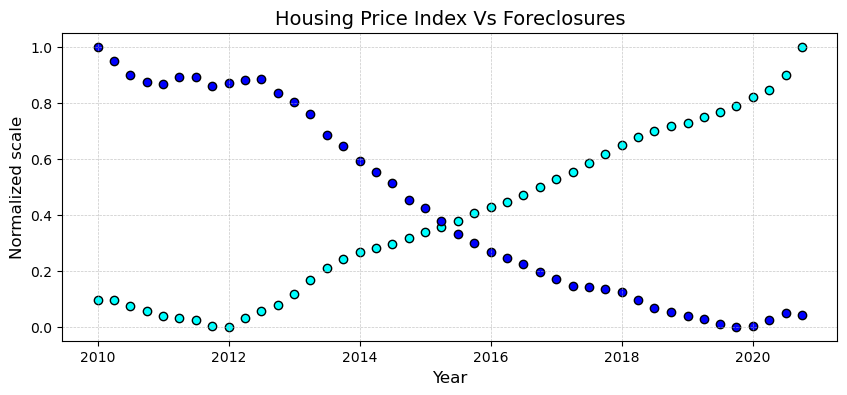

In [645]:
#Scatter plot HPI vs Foreclosures
plt.figure(figsize=(10, 4))
plt.scatter(housing_df.index,housing_df['HPI'], marker="o", facecolors="cyan", edgecolors="black", label='Data Points')
plt.scatter(housing_df.index,housing_df['Foreclosures'], marker="o", facecolors="blue", edgecolors="black", label='Data Points')
#plt.scatter(housing_df.index,housing_df['Mortgage'], marker="o", facecolors="orange", edgecolors="black", label='Data Points')
plt.title("Housing Price Index Vs Foreclosures", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Normalized scale", fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

### Analysis
* HPI and Foreclosures have a strong Negative correlation. 
* When HPI increases, homeowners build equity, reducing the likelihood of foreclosure 

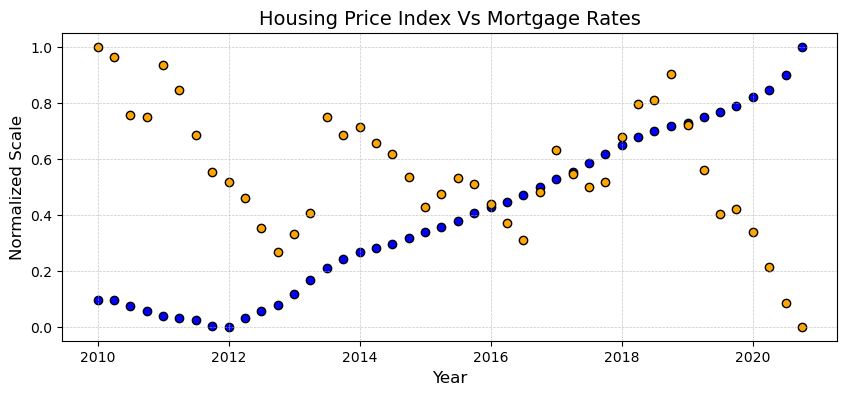

In [642]:
#Scatter plot HPI vs Mortgages
plt.figure(figsize=(10, 4))
plt.scatter(housing_df.index,housing_df['HPI'], marker="o", facecolors="blue", edgecolors="black", label='Data Points')
plt.scatter(housing_df.index,housing_df['Mortgage'], marker="o", facecolors="orange", edgecolors="black", label='Data Points')

plt.title("Housing Price Index Vs Mortgage Rates", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Normalized Scale", fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

## Analysis - HPI Vs Mortgage rates
* HPI VS Mortgage rates has a weak negative correlation
* With high Mortgage rates, demand for houses decreases leading to a decrease in the HPI
* With decreased Mortgage rates, demand for houses increases leading to an increase in the HPI. 



In [643]:
#Calculate correlation between Foreclosure rates and HPI
housing_df.corr()

,Mortgage,Foreclosures,HPI
Mortgage,1.000000,0.358865,-0.383435
Foreclosures,0.358865,1.000000,-0.960798
HPI,-0.383435,-0.960798,1.000000


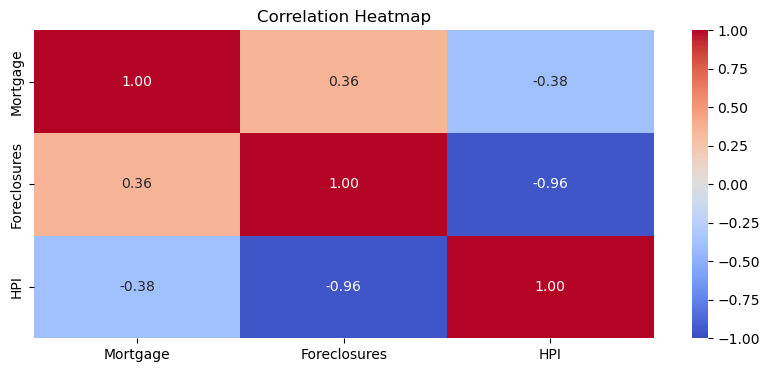

In [644]:
#Correlation heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(housing_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()